##### 2023/12/18 次元圧縮に使うストローク画像を選ぶ

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

INPUT_SIZE = 943

In [2]:
df_box = pd.read_pickle('../temp/abcs_box_nopt.pkl')
img_vector_box = df_box['140*140_img_vector'].to_list()
img_vector_box = np.array(img_vector_box)

##### ▶各線種の数を942個に統一する

In [52]:
# df_box_st = df_box[df_box['shape_int'] == 1]
# df_box_cu = df_box[df_box['shape_int'] == 2]
# df_box_co = df_box[df_box['shape_int'] == 3]
# df_box_ha = df_box[df_box['shape_int'] == 4]

# print('直線  :', len(df_box_st))
# print('曲線  :', len(df_box_cu))
# print('複雑線:', len(df_box_co))
# print('ハッチング:', len(df_box_ha))

# # 線種ごとのデータ数の最小値942(hatching)で統一
# num = 942
# seed = 1

# df_box_st_sample = df_box_st.sample(n=942, random_state=seed)
# df_box_cu_sample = df_box_cu.sample(n=942, random_state=seed)
# df_box_co_sample = df_box_co.sample(n=942, random_state=seed)
# df_box_ha_sample = df_box_ha.sample(n=942, random_state=seed)
# df_box_shape_ratio = pd.concat([df_box_st_sample, df_box_cu_sample, df_box_co_sample, df_box_ha_sample], axis=0)
# df_box_random_shape = sklearn.utils.shuffle(df_box_shape_ratio, random_state=seed)

# # x軸
# x_box_random = np.array(df_box_random_shape['ptx_mm_slide_expand'])
# # y軸
# y_box_random = np.array(df_box_random_shape['pty_mm_slide_expand'])
# # xy軸
# xy_box_random = np.array([ np.concatenate([x, y]) for x, y in zip(x_box_random, y_box_random)])

# df_box_random_shape['ptx_pty_mm_slide_expand'] = xy_box_random
# # pickleファイルに保存
# # df_box_random_shape.to_pickle('../temp/abcs_box_random_shape_seed1.pkl')

# xy_box_random

##### ▶データの読み込み

In [22]:
df = pd.read_pickle('../temp/abcs_box_random_shape_seed1.pkl')

In [103]:
df_straight = df[df['shape_int'] == 1]
df_all = df.copy()
ndarray_straight = np.array([np.array(item) for item in df_straight['ptx_mm_slide_expand'].to_numpy()])
ndarray_all = np.array([np.array(item) for item in df_all['ptx_mm_slide_expand'].to_numpy()])

In [102]:
# plt.grid()
# plt.plot(np.arange(INPUT_SIZE), ndarray_straight[8])
# plt.title("straight")
# plt.show()
# for array in ndarray_all:
#     plt.grid()
#     plt.plot(np.arange(INPUT_SIZE), array)
#     plt.title("all")
#     plt.show()

In [109]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(256, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(64, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(256, activation="relu"),
      layers.Dense(INPUT_SIZE, activation="relu")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [110]:
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam', loss='mae')

In [111]:
history = autoencoder.fit(
    ndarray_straight, ndarray_straight,
    epochs=20,
    batch_size=512,
    validation_data=(ndarray_all, ndarray_all),
    shuffle=True)

Epoch 1/20
2/2 [==============================] - 1s 224ms/step - loss: 149.5918 - val_loss: 116.7805
Epoch 2/20
2/2 [==============================] - 0s 124ms/step - loss: 127.5769 - val_loss: 105.8619
Epoch 3/20
2/2 [==============================] - 0s 118ms/step - loss: 111.7053 - val_loss: 99.5029
Epoch 4/20
2/2 [==============================] - 0s 116ms/step - loss: 100.9941 - val_loss: 93.6571
Epoch 5/20
2/2 [==============================] - 0s 117ms/step - loss: 91.9947 - val_loss: 88.9594
Epoch 6/20
2/2 [==============================] - 0s 116ms/step - loss: 82.8419 - val_loss: 83.9548
Epoch 7/20
2/2 [==============================] - 0s 116ms/step - loss: 74.7961 - val_loss: 80.6733
Epoch 8/20
2/2 [==============================] - 0s 113ms/step - loss: 68.1935 - val_loss: 78.2628
Epoch 9/20
2/2 [==============================] - 0s 114ms/step - loss: 63.4260 - val_loss: 76.2219
Epoch 10/20
2/2 [==============================] - 0s 111ms/step - loss: 59.7826 - val_loss: 7

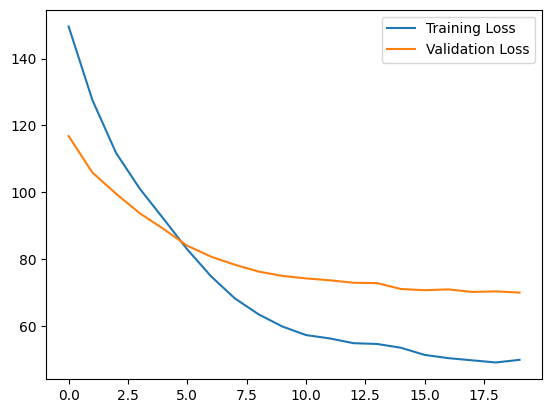

In [112]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

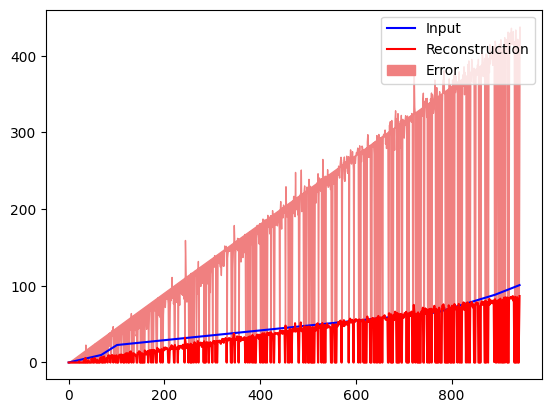

In [117]:
encoded_data = autoencoder.encoder(ndarray_all).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(ndarray_all[10], 'b')
plt.plot(decoded_data[10], 'r')
plt.fill_between(np.arange(INPUT_SIZE), decoded_data[0], ndarray_all[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()